In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from common import *
import pandas as pd
#from mpl_toolkits.mplot3d import Axes3D
import sklearn.linear_model as lm

print(f"Root directory: {os.getcwd()}")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})


Root directory: /Users/gardpavels/uio/fysstk_proj1/FYS-STK4155-Prj1_report/code


### Global variables 

#  Franke function 3D preview
First we plot a 3D plot of the franke function.
The plot is based on the provided code in the assignmentext for plotting the franke function 

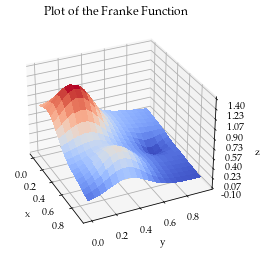

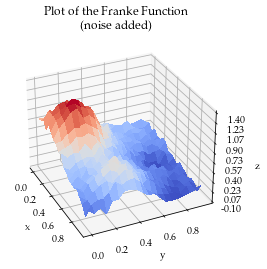

In [2]:
# Preview plot of the franke function
#%matplotlib
np.random.seed(4155)
y = x = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)
z = FrankeFunction(x, y)
noise_mesh = 0.05 * np.random.randn(z.shape[0], z.shape[1]) # Stochastic noise
z_noisy = z + noise_mesh

fig = plt.figure()
# Ploting frankefunction without noise
ax1 = fig.add_subplot(111, projection='3d') # Are :)steike
ax1.title.set_text("Plot of the Franke Function")
ax1.view_init(elev=30., azim=-25.0)
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")
surf1 = ax1.plot_surface(x,y,z, cmap=cm.coolwarm, linewidth = 0, antialiased=False)
# Customize the z axis.
ax1.set_zlim(-0.10, 1.40)
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.savefig(f"{REPORT_FIGURES}{EX1}franke_function_nonoise_preview.pdf")

# Ploting frankefunction with noise
fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
ax2.title.set_text("Plot of the Franke Function\n(noise added)")
ax2.view_init(elev=30., azim=-25.0)
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")
surf2 = ax2.plot_surface(x,y,z_noisy, cmap=cm.coolwarm, linewidth = 0, antialiased=False)
# Customize the z axis.
ax2.set_zlim(-0.10, 1.40)
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.savefig(f"{REPORT_FIGURES}{EX1}franke_function_noise_preview.pdf")
plt.show()

# 1 - Ordinary Least Squeares (OLS)

## 1.1 Data
Defining and creating the data


In [3]:
np.random.seed(4155)
n = 100 # The number of points in direction for the Franke Function
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))
x, y = np.meshgrid(x,y)
z = FrankeFunction(x, y) 
noise = 0.5 * np.random.randn(n,n) # Stochastic noise
#noise = 0.7 * np.random.randn(n) # Stochastic noise
z_noise = z + noise # separate Franke with noise
z += noise # Adding stochastic noise

## 1.2 Plot of fit for all degrees before evaluation
 We plot the fit up to degree 6 to get an intuition on the curvature of the fitted models

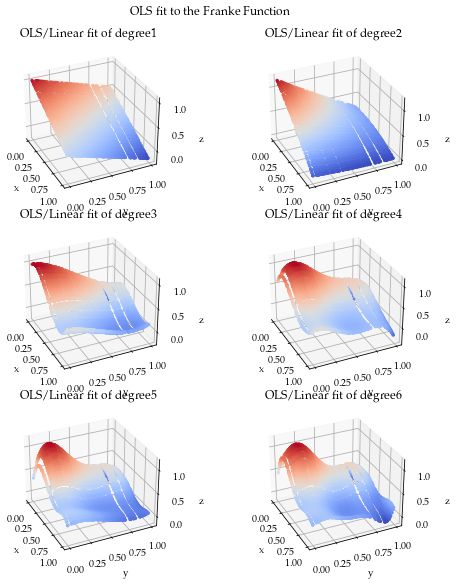

In [4]:
fig = plt.figure(figsize=(8,8))
degrees = 6
z_train_OLS = pd.DataFrame()
z_hat_train_OLS = pd.DataFrame()
z_test_OLS = pd.DataFrame()
z_hat_test_OLS = pd.DataFrame()

# TODO: Must fix so that training and test data are used. 
# Must evalute model using MSE from traning and test
for degree in range(1, degrees + 1):
    X = create_X(x, y, degree) # Design MatrixS
    model = OLS() # The model
    #model.fit(X, z) # Fitting the model
    model.fit(X, z.ravel()) # Fitting the model
    z_hat = model.predict(X) # predict on train data
    
    # Plot
    ax = fig.add_subplot(3,2, degree, projection='3d')
    ax.view_init(elev=30., azim=-25.0)
    ax.title.set_text(f"OLS/Linear fit of degree{degree}")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    ax.scatter3D(y, x, z_hat, c=z_hat ,marker = '.', cmap=cm.coolwarm)
fig.suptitle("OLS fit to the Franke Function")
plt.tight_layout()
plt.savefig(f"{REPORT_FIGURES}{EX1}franke_function_OLS_fit.pdf")
plt.show()

## 1.3 - Finding degree/model complexity for the optimal OLS fit
Approximate the franke function using ordinary least squares
We estimate the franke functinon using polynomials up to 6th degree. We than look at the MSE scores to look for overfitting. We use the MSE score values from the test data to determine overfit together with the curvature of the evaluation plot

### Confidence intervall 
$$CI_{0.95}(\hat\beta_i) = [\hat\beta_i-1.96 SE(\hat\beta_i), \hat\beta_i+1.96 SE(\hat\beta_i)] =\hat\beta_i \pm 1.96\hat \sigma(\hat\beta_i)$$ 
In order to estimate the variance of the $i$-th beta values: $$\sigma^2 (\beta_i ) = \sigma^2 [(X^{T} X)^{-1}]_{ii}$$
However, $\sigma$ is unkown and can be generaly estimated as followed:
$$\hat\sigma^2 = \frac{\sum_{i=0}^{N-1}(y_i - \hat y_i)^2}{N}$$
For simplification purposes, we N instead of N-p-1 in the denominator.<br>
To get the variance estimate of each $\beta$ component one must calculate the variance with respect to the diagonal elements of $(X^TX)^{-1}$ Estimated standard error is the square root of $\hat\sigma^2$, where the estimate for variance $\hat\sigma^2$ is:
$$\hat\sigma^2 = \frac{\sum_{i=0}^{N-1}(y_i - \hat y_i)^2}{N}(X^TX)^{-1}$$
Where y is the true value, and $\hat y$ being the predicted value. <br>
The variance estimate of each $\hat\beta$ estimate can be written as:
$$\hat\sigma_{\hat\beta_i}^2 = \hat\sigma^2(X^TX)_{i,i}^{-1}$$



In [5]:
degrees = 5

# Setting up dataframes for the observed values
z_train_OLS = pd.DataFrame()
z_test_OLS = pd.DataFrame()

# Setting up the dataframes for our computed values
z_hat_train_OLS = pd.DataFrame()
z_hat_test_OLS = pd.DataFrame()

# Setting up the dataframes for our SVD computed values
z_hat_train_SVD = pd.DataFrame()
z_hat_test_SVD = pd.DataFrame()

# Setting up dataframes for sklearn computed values
z_hat_train_SK = pd.DataFrame()
z_hat_test_SK = pd.DataFrame()

coeffs_df = pd.DataFrame()

for degree in range(1, degrees+1):
    X = create_X(x, y, degree) # Design Matrix
    
    # Scaling data and splitting it into training and test sets
    #X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False)
    X_train, X_test, z_train, z_test = prepare_data(X, z.ravel(), test_size=0.2, shuffle=True, scale_X=True, scale_t=False, random_state=4155)
    
    # Model construction, fitting, and predictions using matrix inversion
    model = OLS() # The model
    z_hat_train = model.fit(X_train, z_train, SVDfit = False) # Fitting the model and predict on training data
    z_hat_test = model.predict(X_test) # predict on test data

    # Model construction, fitting and predictions using SVD inversion
    model_svd = OLS()
    z_hat_train_svd = model_svd.fit(X_train, z_train)
    z_hat_test_svd = model.predict(X_test)

    # Model construction, fitting and predictions using sklearn
    model_sk = lm.LinearRegression()
    model_sk.fit(X_train, z_train)
    z_hat_train_sk = model_sk.predict(X_train)
    z_hat_test_sk = model_sk.predict(X_test)
    
    # Evaluatation metrics OLS, SVD, SK
    MSE_score_train = MSE(z_train, z_hat_train)
    R2_score_train = R2(z_train, z_hat_train)
    MSE_score_test = MSE(z_test, z_hat_test)
    R2_score_test = R2(z_test, z_hat_test)

    MSE_score_train_svd = MSE(z_train, z_hat_train_svd)
    R2_score_train_svd = R2(z_train, z_hat_train_svd)
    MSE_score_test_svd = MSE(z_test, z_hat_test_svd)
    R2_score_test_svd = R2(z_test, z_hat_test_svd)

    MSE_score_train_sk = MSE(z_train, z_hat_train_sk)
    R2_score_train_sk = R2(z_train, z_hat_train_sk)
    MSE_score_test_sk = MSE(z_test, z_hat_test_sk)
    R2_score_test_sk = R2(z_test, z_hat_test_sk)
    
    # Estimated standard error for the beta coefficients
    SE_betas = model.SE
    SE_betas_svd = model_svd.SE

    #N, P = X_train.shape
    #var_hat = (1/(N-P-1)) * np.sum((z_train - z_hat_train)**2)
    var_hat = (1/X_train.shape[0]) * np.sum((z_train - z_hat_train)**2) # Estimated variance
    #invXTX_diag = np.diag(np.linalg.inv(X_train.T @ X_train)) 
    #SE_betas = np.sqrt(var_hat * invXTX_diag) # Standard Error

    # Calculating 95% confidence intervall OLS, SVD
    betas = model.get_all_betas
    CI_lower_all_betas = betas - (1.96 * SE_betas)
    CI_upper_all_betas = betas + (1.96 * SE_betas)
    CL = np.zeros((CI_upper_all_betas.shape[0],2))
    CL[:,0] = CI_lower_all_betas
    CL[:,1] = CI_upper_all_betas

    betas_svd = model.get_all_betas

        
    # Printing results
    """
    print(f"Degree: {degree}")
    print(f"Train data - Mean Square Error: {MSE_score_train}")
    print(f"Train data - R2 score: {R2_score_train}")
    print(f"Test data - Mean Square Error: {MSE_score_test}")
    print(f"Test data - R2 score: {R2_score_test}")
    print(f"Estimated variance: {var_hat}")
    print(f"Beta - values{betas}")
    print(f"Beta - Std Errors: {SE_betas}")
    print(f"Beta - Confidence Interval (CI):\n{CL}\n")
    """
    # Constructing dataframe for beta coefficients
    degs = np.zeros(betas.shape[0]); degs.fill(degree)
    df = pd.DataFrame.from_dict({"degree" :degs,
                                 "coeff_name": [f"b{i}" for i in range(1,betas.shape[0]+1)],
                                 "coeff_value": np.round(betas, decimals=4),
                                 "std_error": np.round(SE_betas, decimals=4),
                                 "CI_lower":np.round(CI_lower_all_betas, decimals=4), 
                                 "CI_upper":np.round(CI_upper_all_betas, decimals=4)},
                                 orient='index').T
    
    
    
    
    
    coeffs_df = pd.concat([coeffs_df,df], axis=0)


        
    # Filling up dataframes for train and test evaluation
    z_train_OLS[degree] = z_train.flatten() 
    z_hat_train_OLS[degree] = z_hat_train.flatten()
    z_test_OLS[degree] = z_test.flatten()
    z_hat_test_OLS[degree] = z_hat_test.flatten()

    z_hat_train_SVD[degree] = z_hat_train_svd.flatten()
    z_hat_test_SVD[degree] = z_hat_test_svd.flatten()

    z_hat_train_SK[degree] = z_hat_train_sk.flatten()
    z_hat_test_SK[degree] = z_hat_test_sk.flatten()


# MSE calculations for all lambda values
mse_scores_train = ((z_train_OLS - z_hat_train_OLS) ** 2).mean()
mse_scores_test = ((z_test_OLS - z_hat_test_OLS) ** 2).mean()

mse_scores_train_svd = ((z_train_OLS - z_hat_train_SVD) ** 2).mean()
mse_scores_test_svd = ((z_test_OLS - z_hat_test_SVD) ** 2).mean()

mse_scores_train_sk = ((z_train_OLS - z_hat_train_SK) ** 2).mean()
mse_scores_test_sk = ((z_test_OLS - z_hat_test_SK) ** 2).mean()

# R2 calculations for all lambda values
R2_scores_train = 1 - ((z_train_OLS - z_hat_train_OLS) ** 2).sum() / ((z_train_OLS - z_train_OLS.mean())**2).sum() 
R2_scores_test = 1 - ((z_test_OLS - z_hat_test_OLS) ** 2).sum() / ((z_test_OLS - z_test_OLS.mean())**2).sum()

Degree: 1
Train data - Mean Square Error: 0.26964397350060165
Train data - R2 score: 0.1783560592586002
Test data - Mean Square Error: 0.27689769388425484
Test data - R2 score: 0.19411445704727393
Estimated variance: 0.26964397350060165
Beta - values[ 1.02276952 -0.49278312 -0.71857315]
Beta - Std Errors: [0.01519967 0.0190683  0.02196964]
Beta - Confidence Interval (CI):
[[ 0.99297817  1.05256087]
 [-0.53015699 -0.45540926]
 [-0.76163363 -0.67551266]]

Degree: 2
Train data - Mean Square Error: 0.2643347732837792
Train data - R2 score: 0.19453395536249862
Test data - Mean Square Error: 0.2709558321422254
Test data - R2 score: 0.21140770499366912
Estimated variance: 0.26433477328377925
Beta - values[ 1.17315272 -1.02430344 -0.7663128   0.11810614  0.84612052 -0.35173365]
Beta - Std Errors: [0.02917726 0.08395129 0.09218244 0.07506338 0.0714608  0.08286627]
Beta - Confidence Interval (CI):
[[ 1.11596528  1.23034016]
 [-1.18884798 -0.8597589 ]
 [-0.94699039 -0.58563522]
 [-0.02901809  0.2

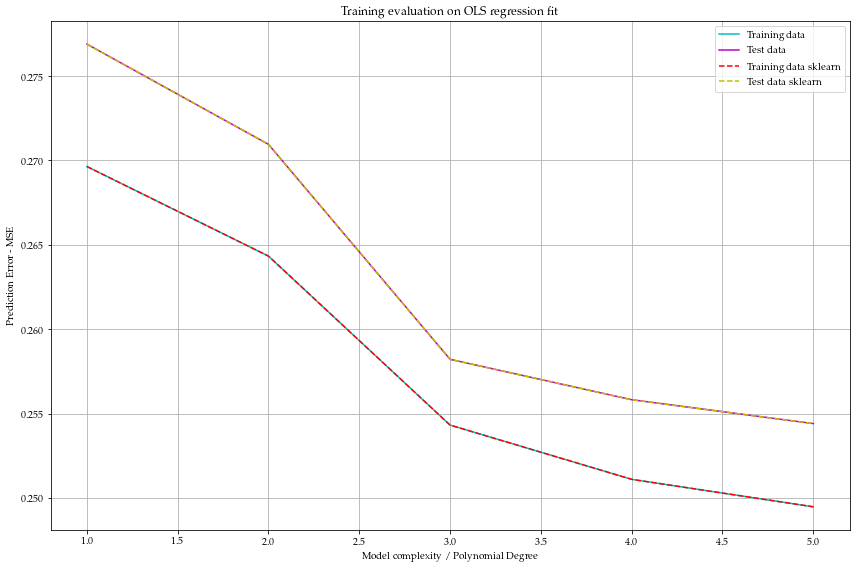

In [6]:
# Plots
plt.figure(figsize=(12,8))
plt.plot(np.arange(1,degrees+1), mse_scores_train, c="c", label="Training data")
plt.plot(np.arange(1,degrees+1), mse_scores_test, c="m", label="Test data")
plt.plot(np.arange(1,degrees+1), mse_scores_train_svd, "b--", label="Training data SVD")
plt.plot(np.arange(1,degrees+1), mse_scores_test_svd, "g--", label="Test data SVD")
plt.plot(np.arange(1,degrees+1), mse_scores_train_sk, "r--", label="Training data sklearn")
plt.plot(np.arange(1,degrees+1), mse_scores_test_sk, "y--", label="Test data sklearn")
plt.xlabel("Model complexity / Polynomial Degree")
plt.ylabel("Prediction Error - MSE")
plt.title("Training evaluation on OLS regression fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{REPORT_FIGURES}{EX1}franke_function_OLS_evaluate_fit_1.pdf")
plt.show()

## 1.4 Analysis of plots and training metrics
Do the analysis.......

Conclusion:<br>
Based on the analysis, we conclude that a model complexity of degree 5 yields the most optimal fit.

## 1.5 plot of the model using the most optimal parameters

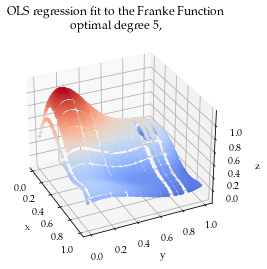

In [7]:
optimal_degree = 5
X = create_X(x, y, optimal_degree) # Design Matrix
model = OLS() # The model
model.fit(X, z.ravel()) # Fitting the model
z_hat = model.predict(X) # predict on train data

# Plot
fig = plt.figure()#figsize=(8,8))
ax = plt.axes(projection='3d')
ax.title.set_text(f"OLS regression fit to the Franke Function\noptimal degree {optimal_degree},")
#ax.view_init(elev=5., azim=85.0)
ax.view_init(elev=30., azim=-25.0)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.scatter3D(y, x, z_hat, c=z_hat ,marker = '.', cmap=cm.coolwarm)
plt.savefig(f"{REPORT_FIGURES}{EX1}franke_function_OLS_best_fit.pdf")
plt.show()

## Looking at $\beta$ values

,degree,coeff_name,coeff_value,std_error,CI_lower,CI_upper
0,5.0,b1,0.255,0.1116,0.0363,0.4738
1,5.0,b2,9.4457,1.1878,7.1177,11.7738
2,5.0,b3,3.6233,1.2233,1.2256,6.021
3,5.0,b4,-38.268,5.3896,-48.8316,-27.7045
4,5.0,b5,-21.0914,4.4496,-29.8125,-12.3702
5,5.0,b6,-4.7007,5.8442,-16.1553,6.754
6,5.0,b7,52.6345,11.6459,29.8086,75.4605
7,5.0,b8,59.3324,9.7245,40.2723,78.3924
8,5.0,b9,23.274,9.1904,5.2608,41.2872
9,5.0,b10,-18.2234,13.0222,-43.747,7.3002


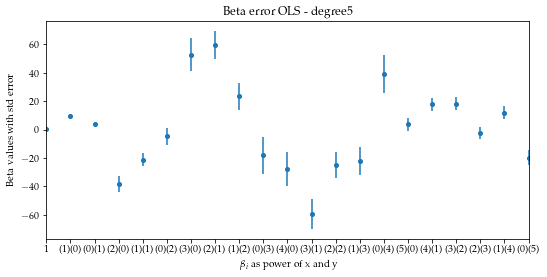

In [8]:
optimal_degree_coeffs = coeffs_df[coeffs_df["degree"] == optimal_degree]
display(optimal_degree_coeffs)
optimal_degree_coeffs.to_csv(f"{REPORT_DATA}{EX1}coeffs_optimal_degree.csv")

fig = plot_beta_errors(optimal_degree_coeffs, optimal_degree)
fig.savefig(f"{REPORT_FIGURES}{EX1}OLS_beta_error_degree{optimal_degree}.pdf")

Repeat of the previous exercise, this time with scaled data to study the difference for OLS with and without scaled data
(Hint: there should be no difference in MSE for OLS given scaled data)

In [9]:
# Setting up dataframes for the observed values
z_train_OLS = pd.DataFrame()
z_test_OLS = pd.DataFrame()

# Setting up the dataframes for our computed values
z_hat_train_OLS = pd.DataFrame()
z_hat_test_OLS = pd.DataFrame()

# Setting up the dataframes for our SVD computed values
z_hat_train_SVD = pd.DataFrame()
z_hat_test_SVD = pd.DataFrame()

# Setting up dataframes for sklearn computed values
z_hat_train_sk = pd.DataFrame()
z_hat_test_sk = pd.DataFrame()

coeffs_df = pd.DataFrame()

for degree in range(1, degrees+1):
    X = create_X(x, y, degree)[:,1:] # Design Matrix
    
    # Scaling data and splitting it into training and test sets
    #X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False)
    X_train, X_test, z_train, z_test = prepare_data(X, z.ravel(), test_size=0.2, shuffle=True, scale_X=True, scale_t=True, zero_center = True, random_state=4155)
    
    # Model construction, fitting, and predictions using matrix inversion
    model = OLS() # The model
    z_hat_train = model.fit(X_train, z_train, SVDfit = False) # Fitting the model and predict on training data
    z_hat_test = model.predict(X_test) # predict on test data

    # Model construction, fitting and predictions using SVD inversion
    model_svd = OLS()
    z_hat_train_svd = model_svd.fit(X_train, z_train)
    z_hat_test_svd = model.predict(X_test)

    # Model construction, fitting and predictions using sklearn
    model_sk = lm.LinearRegression(fit_intercept=False)
    model_sk.fit(X_train, z_train)
    z_hat_train_sk = model_sk.predict(X_train)
    z_hat_test_sk = model_sk.predict(X_test)
    
    # Evaluatation metrics OLS, SVD, SK
    MSE_score_train = MSE(z_train, z_hat_train)
    R2_score_train = R2(z_train, z_hat_train)
    MSE_score_test = MSE(z_test, z_hat_test)
    R2_score_test = R2(z_test, z_hat_test)

    MSE_score_train_svd = MSE(z_train, z_hat_train_svd)
    R2_score_train_svd = R2(z_train, z_hat_train_svd)
    MSE_score_test_svd = MSE(z_test, z_hat_test_svd)
    R2_score_test_svd = R2(z_test, z_hat_test_svd)

    MSE_score_train_sk = MSE(z_train, z_hat_train_sk)
    R2_score_train_sk = R2(z_train, z_hat_train_sk)
    MSE_score_test_sk = MSE(z_test, z_hat_test_sk)
    R2_score_test_sk = R2(z_test, z_hat_test_sk)
    
    # Estimated standard error for the beta coefficients
    SE_betas = model.SE
    SE_betas_svd = model_svd.SE

    #N, P = X_train.shape
    #var_hat = (1/(N-P-1)) * np.sum((z_train - z_hat_train)**2)
    var_hat = (1/X_train.shape[0]) * np.sum((z_train - z_hat_train)**2) # Estimated variance
    #invXTX_diag = np.diag(np.linalg.inv(X_train.T @ X_train)) 
    #SE_betas = np.sqrt(var_hat * invXTX_diag) # Standard Error

    # Calculating 95% confidence intervall OLS, SVD
    betas = model.get_all_betas
    CI_lower_all_betas = betas - (1.96 * SE_betas)
    CI_upper_all_betas = betas + (1.96 * SE_betas)
    CL = np.zeros((CI_upper_all_betas.shape[0],2))
    CL[:,0] = CI_lower_all_betas
    CL[:,1] = CI_upper_all_betas

    betas_svd = model.get_all_betas

        
    # Printing results
    print(f"Degree: {degree}")
    print(f"Train data - Mean Square Error: {MSE_score_train}")
    print(f"Train data - R2 score: {R2_score_train}")
    print(f"Test data - Mean Square Error: {MSE_score_test}")
    print(f"Test data - R2 score: {R2_score_test}")
    print(f"Estimated variance: {var_hat}")
    print(f"Beta - values{betas}")
    print(f"Beta - Std Errors: {SE_betas}")
    print(f"Beta - Confidence Interval (CI):\n{CL}\n")

    # Constructing dataframe for beta coefficients
    degs = np.zeros(betas.shape[0]); degs.fill(degree)
    df = pd.DataFrame.from_dict({"degree" :degs,
                                 "coeff name": [f"b{i}" for i in range(1,betas.shape[0]+1)],
                                 "coeff value": np.round(betas, decimals=4),
                                 "Std Error": np.round(SE_betas, decimals=4),
                                 "CI lower":np.round(CI_lower_all_betas, decimals=4), 
                                 "CI_upper":np.round(CI_upper_all_betas, decimals=4)},
                                 orient='index').T
    coeffs_df = pd.concat([coeffs_df,df], axis=0)
        
    # Filling up dataframes for train and test evaluation
    z_train_OLS[degree] = z_train.flatten() 
    z_hat_train_OLS[degree] = z_hat_train.flatten()
    z_test_OLS[degree] = z_test.flatten()
    z_hat_test_OLS[degree] = z_hat_test.flatten()

    z_hat_train_SVD[degree] = z_hat_train_svd.flatten()
    z_hat_test_SVD[degree] = z_hat_test_svd.flatten()


# MSE calculations for all lambda values
mse_scores_train = ((z_train_OLS - z_hat_train_OLS) ** 2).mean()
mse_scores_test = ((z_test_OLS - z_hat_test_OLS) ** 2).mean()

mse_scores_train_svd = ((z_train_OLS - z_hat_train_SVD) ** 2).mean()
mse_scores_test_svd = ((z_test_OLS - z_hat_test_SVD) ** 2).mean()
# R2 calculations for all lambda values
#R2_scores_train = 1 - ((z_train_OLS - z_hat_train_OLS) ** 2).sum() / ((z_train_OLS - z_train_OLS.mean())**2).sum() 
#R2_scores_test = 1 - ((z_test_OLS - z_hat_test_OLS) ** 2).sum() / ((z_test_OLS - z_test_OLS.mean())**2).sum()

Degree: 1
Train data - Mean Square Error: 0.26964397350060165
Train data - R2 score: 0.1783560592586002
Test data - Mean Square Error: 0.2768954649714867
Test data - R2 score: 0.1941209440950754
Estimated variance: 0.26964397350060165
Beta - values[-0.49278312 -0.71857315]
Beta - Std Errors: [0.0190683  0.02196964]
Beta - Confidence Interval (CI):
[[-0.53015699 -0.45540926]
 [-0.76163363 -0.67551266]]

Degree: 2
Train data - Mean Square Error: 0.26433477328377925
Train data - R2 score: 0.1945339553624984
Test data - Mean Square Error: 0.2709541533964545
Test data - R2 score: 0.21141259083048514
Estimated variance: 0.2643347732837793
Beta - values[-1.02430344 -0.7663128   0.11810614  0.84612052 -0.35173365]
Beta - Std Errors: [0.08395129 0.09218244 0.07506338 0.0714608  0.08286627]
Beta - Confidence Interval (CI):
[[-1.18884798 -0.8597589 ]
 [-0.94699039 -0.58563522]
 [-0.02901809  0.26523037]
 [ 0.70605735  0.98618369]
 [-0.51415153 -0.18931576]]

Degree: 3
Train data - Mean Square Err

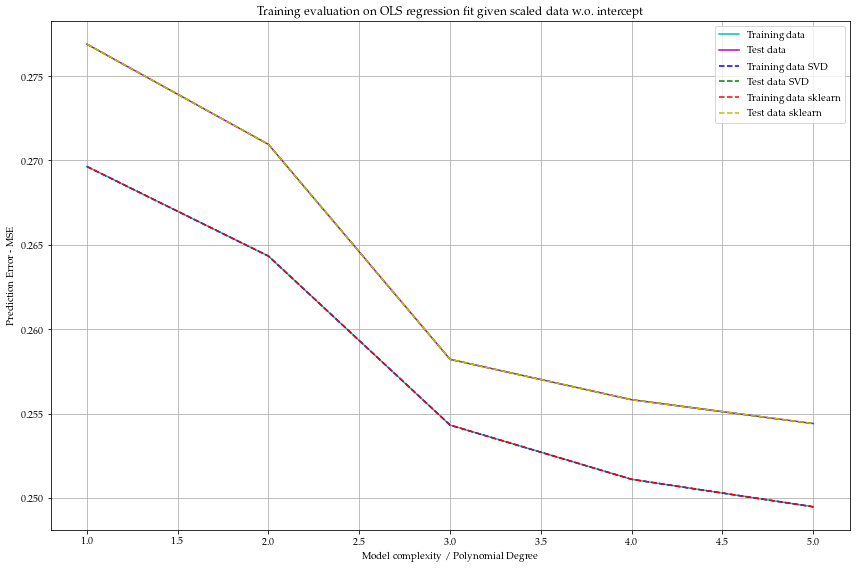

In [10]:
# Plots
plt.figure(figsize=(12,8))
plt.plot(np.arange(1,degrees+1), mse_scores_train, c="c", label="Training data")
plt.plot(np.arange(1,degrees+1), mse_scores_test, c="m", label="Test data")
plt.plot(np.arange(1,degrees+1), mse_scores_train_svd, "b--", label="Training data SVD")
plt.plot(np.arange(1,degrees+1), mse_scores_test_svd, "g--", label="Test data SVD")
plt.plot(np.arange(1,degrees+1), mse_scores_train_sk, "r--", label="Training data sklearn")
plt.plot(np.arange(1,degrees+1), mse_scores_test_sk, "y--", label="Test data sklearn")
plt.xlabel("Model complexity / Polynomial Degree")
plt.ylabel("Prediction Error - MSE")
plt.title("Training evaluation on OLS regression fit given scaled data w.o. intercept")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{REPORT_FIGURES}{EX1}franke_function_OLS_evaluate_fit.pdf")
plt.show()

# test of summary functnion


In [11]:
optimal_degree = 2
X = create_X(x, y, optimal_degree) # Design Matrix
model = OLS(optimal_degree) # The model
z_hat_train = model.fit(X, z.ravel()) # Fitting the model & predict on train data
summary = model.summary()
display(summary)

,degree,coeff_name,coeff_value,std_error,CI_lower,CI_upper
0,2.0,b_0,1.1853,0.0263,1.1338,1.2368
1,2.0,b_1,-1.0057,0.0755,-1.1537,-0.8578
2,2.0,b_2,-0.8095,0.0826,-0.9714,-0.6475
3,2.0,b_3,0.0809,0.0673,-0.051,0.2128
4,2.0,b_4,0.8684,0.064,0.7429,0.9939
5,2.0,b_5,-0.3288,0.074,-0.4738,-0.1838


In [12]:
optimal_lambda = -1
X = create_X(x, y, 3) # Design Matrix
model = RidgeRegression(optimal_lambda) # The model
z_hat_train = model.fit(X, z.ravel()) # Fitting the model & predict on train data
summary = model.summary()
display(summary)

,lambda,coeff_name,coeff_value,std_error,CI_lower,CI_upper
0,-1.0,b_0,2.5752,0.0497,2.4778,2.6725
1,-1.0,b_1,-1.8802,0.2568,-2.3835,-1.3768
2,-1.0,b_2,-9.9465,0.2637,-10.4633,-9.4296
3,-1.0,b_3,-5.7886,0.5112,-6.7905,-4.7868
4,-1.0,b_4,15.6757,0.3975,14.8967,16.4548
5,-1.0,b_5,12.168,0.5238,11.1413,13.1946
6,-1.0,b_6,5.1704,0.3228,4.5377,5.8031
7,-1.0,b_7,-4.0046,0.2839,-4.5611,-3.4481
8,-1.0,b_8,-10.459,0.2711,-10.9904,-9.9277
9,-1.0,b_9,-4.686,0.3314,-5.3355,-4.0365
